In [1]:
import glob
import calendar
import iris
import xarray as xr
import numpy as np
import xesmf as xe
import dask.diagnostics
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import os
import warnings
import geopandas as gp
from iris.coord_categorisation import add_month
import iris.plot as iplt
os.chdir("/home/548/eh6215/Desktop/python/BARPA_evaluation/emma/long_trials/ACS_consistent")
import spatial_selection
os.chdir("/home/548/eh6215/Desktop/python/BARPA_evaluation/emma/lib")
from plotting_functions import bias_plots

In [2]:
nrm_clusters = gp.read_file('/short/tp28/eh6215/NRM_clusters/NRM_clusters.shp')
nrm_sub_clusters = gp.read_file('/short/tp28/eh6215//NRM_sub_clusters/NRM_sub_clusters.shp')


In [3]:
start_date = "1980-01-01"
end_date = "1990-01-01"
years = np.arange(1980,1990)
cx = iris.Constraint(longitude=lambda x: 110<=x<=155)
cy = iris.Constraint( latitude=lambda y: -45<=y<=-10)

In [4]:
# Get BARPA data
# BARPA data copied from /scratch/tp28/cst565/postproc_DRS_v0.1/
# update and generalise later, at the moment we only have the one run postprocessed anyway
#path = "/g/data/tp28/dev/eh6215/proto_lev1_v0.1/CORDEX-CMIP6/output/AUS-17i/BOM/CSIRO-BOM-ACCESS-CM2/historical/r4i1p1f1/BOM-BARPA-R/v1/mon"
#barpa = iris.load_cube([os.path.join(path,f"tasmax/tasmax_AUS-17i_CSIRO-BOM-ACCESS-CM2_historical_r4i1p1f1_BOM-BARPA-R_v1_mon_{year}01-{year}12.nc") for year in years])

path = "/short/tp28/eh6215//monthly/{trial}/{year}_means.nc"
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    barpa = iris.load([path.format(trial="cg282_ACCESS-CM2_historical_1979_r6p",year=year) for year in years],"tmax").extract(cx&cy)

iris.util.equalise_attributes(barpa)
barpa = barpa.concatenate_cube()

In [5]:
lsm = iris.load_cube("/g/data/tp28/dev/barpa/ancils/barpa-r/land_sea_mask/cci/qrparm.mask.nc","land_binary_mask")
lsm.coord('longitude').bounds = None
lsm.coord('latitude').bounds = None
lsm=lsm.extract(cx&cy)
barpa.data = np.ma.masked_array(barpa.data,mask=np.ones(barpa.shape)*1-lsm.data)

In [6]:
print(barpa.summary(shorten=True))
print(lsm.summary(shorten=True))

Tmax / (Celsius)                    (time: 120; latitude: 227; longitude: 291)
land_binary_mask / (1)              (latitude: 227; longitude: 291)


In [7]:
agcd_years = np.arange(1980,1990, 1)
agcd_pr_files = [f'/g/data/zv2/agcd/v1/tmax/mean/r005/01month/agcd_v1_tmax_mean_r005_monthly_{year}.nc' for year in agcd_years]
agcd = iris.load(agcd_pr_files,cx&cy)
iris.util.equalise_attributes(agcd)
agcd = agcd.concatenate_cube()

In [33]:
barpa.coord('longitude').guess_bounds()
barpa.coord('latitude').guess_bounds()
agcd.coord('longitude').coord_system = None
agcd.coord('latitude').coord_system = None
agcd = agcd.regrid(barpa, iris.analysis.AreaWeighted())
agcd.data = np.ma.masked_array(agcd.data,mask=np.ones(agcd.shape)*1-lsm.data)

In [10]:
print(agcd.summary(shorten=True))

air_temperature / (degrees_Celsius) (time: 120; latitude: 227; longitude: 291)


In [11]:
agcd_annual_clim = agcd.collapsed('time',iris.analysis.MEAN)
barpa_annual_clim = barpa.collapsed('time',iris.analysis.MEAN)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/coords.py:1982: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(msg.format(self.name()))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/coords.py:1982: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'forecast_period'.
  warnings.warn(msg.format(self.name()))


/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/coords.py:1982: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(msg.format(self.name()))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/coords.py:1982: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'forecast_period'.
  warnings.warn(msg.format(self.name()))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/cube.py:3523: UserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(msg.format(coord.name()))


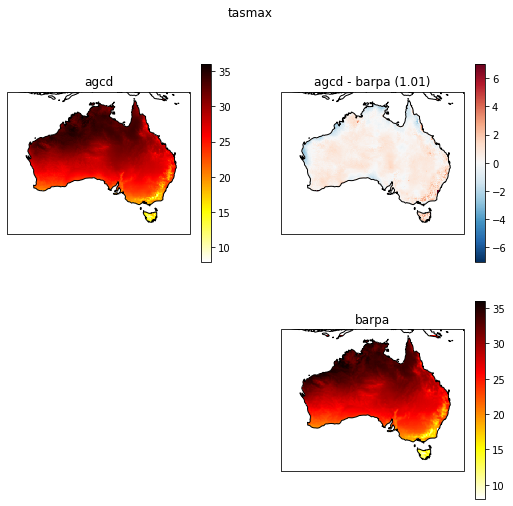

In [86]:
figure = plt.figure(figsize=(9,8))
bias_plots({'agcd':agcd,'barpa':barpa},"tasmax",False,['agcd','barpa'],8,36,7,'hot_r','RdBu_r',"Celsius",offset=0,Constraints=None)

In [35]:
add_month(barpa,'time','month')
add_month(agcd,'time','month')
barpa_m = barpa.aggregated_by('month',iris.analysis.MEAN)
agcd_m = agcd.aggregated_by('month',iris.analysis.MEAN)

In [88]:
import iris.analysis.stats as istats
corr_t = iris.analysis.stats.pearsonr(barpa_m,agcd_m,'month')
barpa_std = barpa_m.collapsed('month',iris.analysis.STD_DEV)
agcd_std = agcd_m.collapsed('month',iris.analysis.STD_DEV)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/coords.py:1982: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(msg.format(self.name()))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/coords.py:1982: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'forecast_period'.
  warnings.warn(msg.format(self.name()))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/coords.py:1982: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(msg.format(self.name()))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/coords.py:1982: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(msg.format(self.na

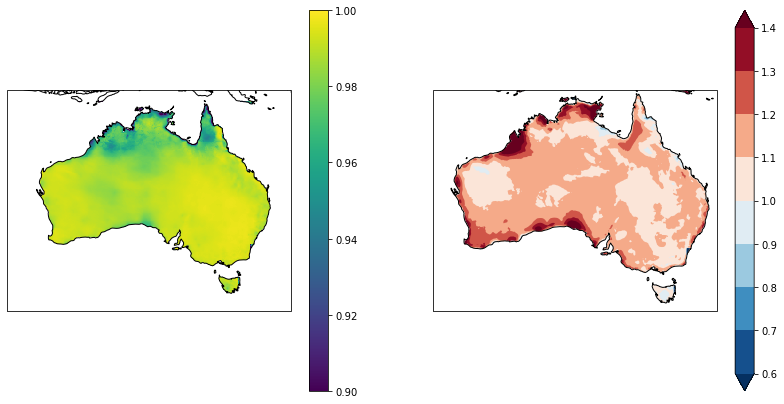

In [89]:
fig = plt.figure(figsize=[14, 7])
ax=plt.subplot(121,projection=ccrs.PlateCarree())
iplt.pcolormesh(corr_t,vmin=0.9,vmax=1,cmap='viridis')
plt.colorbar()
ax.coastlines()
ax=plt.subplot(122,projection=ccrs.PlateCarree())
iplt.contourf(barpa_std/agcd_std,levels=[0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4],cmap='RdBu_r',extend='both')
plt.colorbar()
ax.coastlines()


In [68]:
#barpa_m.coord('latitude').rename('lat')
#barpa_m.coord('longitude').rename('lon')
#agcd_m.coord('latitude').rename('lat')
#agcd_m.coord('longitude').rename('lon')
barpa_x = xr.DataArray.from_iris(barpa_m)
agcd_x = xr.DataArray.from_iris(agcd_m)

In [63]:
barpa_x

<xarray.DataArray 'tmax' (time_0: 12, lat: 227, lon: 291)>
[792684 values with dtype=float64]
Coordinates:
  * time_0                   (time_0) datetime64[ns] 1984-07-17T12:07:29.9999...
  * lat                      (lat) float64 -44.92 -44.77 ... -10.16 -10.01
  * lon                      (lon) float64 110.1 110.3 110.4 ... 154.8 154.9
    forecast_reference_time  datetime64[ns] ...
    height                   float64 ...
    forecast_period_0        (time_0) timedelta64[ns] ...
    month                    (time_0) <U64 ...
Attributes:
    long_name:                      Tmax
    units:                          Celsius
    Dataset_identifier:             BARPA_R
    Institution:                    Australian Bureau of Meteorology, GPO Box...
    Keywords:                       Earth Science Services, Models, Earth Sci...
    Naming_authority:               au.gov.bom
    Project:                        BARPA: Bureau of Meteorology Atmospheric ...
    Publisher_institution:          Australian Bureau of Meteorology
    Publisher_name:                 Australian Bureau of Meteorology
    Publisher_type:                 Institution
    Publisher_url:                  http://www.bom.gov.au
    Title:                          Bureau of Meteorology Atmospheric high-re...
    cf_standard_name_table:         cf-standard-name-table.xml.v78
    compression_level:              4
    fletcher32:                     True
    geospatial_lat_resolution:      0.1545
    geospatial_lat_resolution_max:  0.15450287
    geospatial_lat_resolution_min:  0.15449524
    geospatial_lon_resolution_max:  0.1545105
    geospatial_lon_resolution_min:  0.15447998
    keywords_reference:             Global Change Master Directory (GCMD). 20...
    keywords_vocabulary:            GCMD Science Keywords, Version 8.5
    processing_level:               Level 0b: Conversion from Unified Model (...
    product_version:                trial
    py_dask_version:                2021.12.0
    py_h5py_version:                3.6.0
    py_iris_version:                3.1.0
    py_netCDF4_version:             1.5.6
    py_numpy_version:               1.22.0
    py_xarray_version:              0.20.2
    shuffle:                        True
    source:                         Data from Met Office Unified Model
    stash_references:               /g/data/access/projects/access/umdir/vn11...
    stash_vocabulary:               http://reference.metoffice.gov.uk/um/stash
    suite_name:                     u-cg282
    suite_url:                      https://code.metoffice.gov.uk/svn/roses-u...
    suite_version_number:           223513
    um_version:                     11.9
    zlib:                           True
    cell_methods:                   doyr: maximum time: mean month: mean

In [69]:
barpa_monthly_clim_nrm_clusters = spatial_selection.select_shapefile_regions(
barpa_x,
    nrm_clusters,
    agg='weighted_mean',
    header='label'
)
agcd_monthly_clim_nrm_clusters = spatial_selection.select_shapefile_regions(
agcd_x,
    nrm_clusters,
    agg='weighted_mean',
    header='label'
)


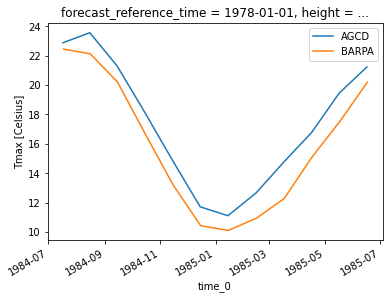

In [84]:
agcd_monthly_clim_nrm_clusters.sel({'region': 'Southern Slopes'}).plot(label='AGCD')
barpa_monthly_clim_nrm_clusters.sel({'region': 'Southern Slopes'}).plot(label='BARPA')
xticks = np.arange(1,13)
xlabels = [calendar.month_abbr[i] for i in xticks]
#plt.xticks(xticks, xlabels)
plt.legend()
plt.show()

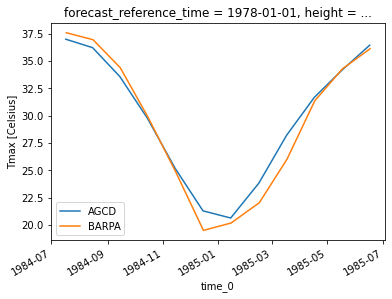

In [85]:
agcd_monthly_clim_nrm_clusters.sel({'region': 'Rangelands'}).plot(label='AGCD')
barpa_monthly_clim_nrm_clusters.sel({'region': 'Rangelands'}).plot(label='BARPA')
xticks = np.arange(1,13)
xlabels = [calendar.month_abbr[i] for i in xticks]
#plt.xticks(xticks, xlabels)
plt.legend()
plt.show()

In [99]:
corr_x = iris.analysis.stats.pearsonr(barpa_m,agcd_m,['lon','lat'])


In [100]:
corr_x.data
corr_x.collapsed('month',iris.analysis.MEAN).data

/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/coords.py:1982: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'forecast_period'.
  warnings.warn(msg.format(self.name()))


array(0.97101401)

In [105]:
barpa_std_x = barpa_m.collapsed(['lon','lat'],iris.analysis.STD_DEV)
agcd_std_x = agcd_m.collapsed(['lon','lat'],iris.analysis.STD_DEV)


In [108]:
print(barpa_std_x.data.mean()/agcd_std_x.data.mean())

1.073026845310961
